In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from alphatoe import plot, game, data
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from functools import partial
from copy import copy
import tqdm
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
weights = torch.load("../scripts/models/prob all 8 layer control-20230718-185339.pt")
with open("../scripts/models/prob all 8 layer control-20230718-185339.json", "r") as f:
    args = json.load(f)

In [3]:
model_cfg = HookedTransformerConfig(
    n_layers=args["n_layers"],
    n_heads=args["n_heads"],
    d_model=args["d_model"],
    d_head=args["d_head"],
    d_mlp=args["d_mlp"],
    act_fn=args["act_fn"],
    normalization_type=args["normalization_type"],
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device=args["device"],
    seed=args["seed"],
)
model = HookedTransformer(model_cfg)
model.load_state_dict(weights)

<All keys matched successfully>

In [33]:
neurons = [5, 117, 160, 195, 248, 342, 384]
loss_fn = F.cross_entropy


def get_neuron_acts(model, seq):
    with torch.no_grad():
        logits, cache = model.run_with_cache(torch.tensor(seq))
    neuron_activations = copy(cache["post", 0][0])
    return neuron_activations


def ablate_one_neuron(neuron, seq):
    def hook(module, input, output):
        result = output.clone()
        result[:, :, neuron] = 0
        return result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        logits = model(torch.tensor(seq))
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return logits


def neuron_ablated_loss(data, neuron):
    data_size = data.shape[0]
    target = einops.repeat(
        torch.tensor([0.0] * 9 + [1.0]),
        "logit_dim -> data_size logit_dim",
        data_size=data_size,
    ).to("cuda")
    logits = ablate_one_neuron(neuron, data)[:, -1, :]
    loss = F.cross_entropy(logits, target, reduction="none")
    loss.to("cpu").detach().numpy()
    return loss

In [5]:
df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
# count uniques in df
first_conditions = Counter(df["first win condition"])
second_conditions = Counter(df["second win condition"])
for key, val in (first_conditions + second_conditions).items():
    if isinstance(key, str):
        print(f"{key}: {val}")

left column: 24228
top left -> bottom right: 38196
top row: 24228
middle column: 24228
bottom left -> top right: 38196
right column: 24228
middle row: 24228
bottom row: 24228


/tmp/ipykernel_57662/4271538171.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


In [12]:
df.head()

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [39]:
# long run time
batch_restarts = (
    [0]
    + [df.loc[df["steps till end state"] == i].index[0] for i in [6, 7, 8, 9]]
    + [len(df)]
)
batch_size = 4096
df_ablation_losses = pd.DataFrame(columns=["moves played"] + neurons)
with torch.no_grad():
    for neuron in neurons:
        neuron_losses = []
        for j in range(len(batch_restarts) - 1):
            batch_size = min(batch_restarts[j + 1], batch_size)
            for i in range(batch_restarts[j], batch_restarts[j + 1], batch_size):
                batch_gap = batch_restarts[j + 1] - i
                batch_size = batch_gap if batch_gap < batch_size else batch_size
                games = torch.stack(
                    [
                        torch.tensor([10] + eval(game))
                        for game in df["moves played"].iloc[i : i + batch_size]
                    ]
                ).to("cuda")
                loss = neuron_ablated_loss(games, neuron)
                neuron_losses.append(loss)
        inter = [
            loss.item()
            for loss in torch.cat(
                [torch.flatten(batch_losses) for batch_losses in neuron_losses]
            )
        ]

        df_ablation_losses[neuron] = inter

/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5  117  160  195  248  342  384
0          NaN  1.097605  NaN  NaN  NaN  NaN  NaN  NaN
1          NaN  3.076243  NaN  NaN  NaN  NaN  NaN  NaN
2          NaN  1.423348  NaN  NaN  NaN  NaN  NaN  NaN
3          NaN  1.009675  NaN  NaN  NaN  NaN  NaN  NaN
4          NaN  1.193816  NaN  NaN  NaN  NaN  NaN  NaN


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117  160  195  248  342  384
0          NaN  1.097605  0.000362  NaN  NaN  NaN  NaN  NaN
1          NaN  3.076243  0.002625  NaN  NaN  NaN  NaN  NaN
2          NaN  1.423348  0.000116  NaN  NaN  NaN  NaN  NaN
3          NaN  1.009675  0.000683  NaN  NaN  NaN  NaN  NaN
4          NaN  1.193816  0.000973  NaN  NaN  NaN  NaN  NaN


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117       160  195  248  342  384
0          NaN  1.097605  0.000362  0.000005  NaN  NaN  NaN  NaN
1          NaN  3.076243  0.002625  0.000114  NaN  NaN  NaN  NaN
2          NaN  1.423348  0.000116  0.000007  NaN  NaN  NaN  NaN
3          NaN  1.009675  0.000683  0.000008  NaN  NaN  NaN  NaN
4          NaN  1.193816  0.000973  0.000013  NaN  NaN  NaN  NaN


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117       160       195  248  342  384
0          NaN  1.097605  0.000362  0.000005  0.000005  NaN  NaN  NaN
1          NaN  3.076243  0.002625  0.000114  0.000114  NaN  NaN  NaN
2          NaN  1.423348  0.000116  0.000007  0.000007  NaN  NaN  NaN
3          NaN  1.009675  0.000683  0.000008  0.000008  NaN  NaN  NaN
4          NaN  1.193816  0.000973  0.000013  0.000013  NaN  NaN  NaN


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117       160       195       248  342  384
0          NaN  1.097605  0.000362  0.000005  0.000005  0.000005  NaN  NaN
1          NaN  3.076243  0.002625  0.000114  0.000114  0.000114  NaN  NaN
2          NaN  1.423348  0.000116  0.000007  0.000007  0.000007  NaN  NaN
3          NaN  1.009675  0.000683  0.000008  0.000008  0.000008  NaN  NaN
4          NaN  1.193816  0.000973  0.000013  0.000013  0.000013  NaN  NaN


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117       160       195       248       342   
0          NaN  1.097605  0.000362  0.000005  0.000005  0.000005  0.001539  \
1          NaN  3.076243  0.002625  0.000114  0.000114  0.000114  0.088433   
2          NaN  1.423348  0.000116  0.000007  0.000007  0.000007  0.002219   
3          NaN  1.009675  0.000683  0.000008  0.000008  0.000008  0.002747   
4          NaN  1.193816  0.000973  0.000013  0.000013  0.000013  0.001735   

   384  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  


/tmp/ipykernel_57662/1016717474.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(seq))


  moves played         5       117       160       195       248       342   
0          NaN  1.097605  0.000362  0.000005  0.000005  0.000005  0.001539  \
1          NaN  3.076243  0.002625  0.000114  0.000114  0.000114  0.088433   
2          NaN  1.423348  0.000116  0.000007  0.000007  0.000007  0.002219   
3          NaN  1.009675  0.000683  0.000008  0.000008  0.000008  0.002747   
4          NaN  1.193816  0.000973  0.000013  0.000013  0.000013  0.001735   

        384  
0  0.000005  
1  0.000114  
2  0.000007  
3  0.000008  
4  0.000013  


In [40]:
df_ablation_losses["moves played"] = df["moves played"]
df_ablation_losses["first win condition"] = df["first win condition"]
df_ablation_losses["second win condition"] = df["second win condition"]

In [41]:
# save csv
df_ablation_losses.to_csv("../data/230801_mlp_neuron_ablations.csv", index=False)

In [48]:
df_ablation_losses.head()

,moves played,5,117,160,195,248,342,384,first win condition,second win condition
0,"[0, 1, 3, 2, 6]",1.097605,0.000362,0.000005,0.000005,0.000005,0.001539,0.000005,left column,NaN
1,"[0, 1, 3, 4, 6]",3.076243,0.002625,0.000114,0.000114,0.000114,0.088433,0.000114,left column,NaN
2,"[0, 1, 3, 5, 6]",1.423348,0.000116,0.000007,0.000007,0.000007,0.002219,0.000007,left column,NaN
3,"[0, 1, 3, 7, 6]",1.009675,0.000683,0.000008,0.000008,0.000008,0.002747,0.000008,left column,NaN
4,"[0, 1, 3, 8, 6]",1.193816,0.000973,0.000013,0.000013,0.000013,0.001735,0.000013,left column,NaN


In [58]:
df_ablation_losses.drop("second win condition", axis=1, inplace=True)
df_ablation_losses.drop("moves played", axis=1, inplace=True)

KeyError: "['moves played'] not found in axis"

In [59]:
df_ablation_losses.head()

,5,117,160,195,248,342,384,first win condition
0,1.097605,0.000362,0.000005,0.000005,0.000005,0.001539,0.000005,left column
1,3.076243,0.002625,0.000114,0.000114,0.000114,0.088433,0.000114,left column
2,1.423348,0.000116,0.000007,0.000007,0.000007,0.002219,0.000007,left column
3,1.009675,0.000683,0.000008,0.000008,0.000008,0.002747,0.000008,left column
4,1.193816,0.000973,0.000013,0.000013,0.000013,0.001735,0.000013,left column


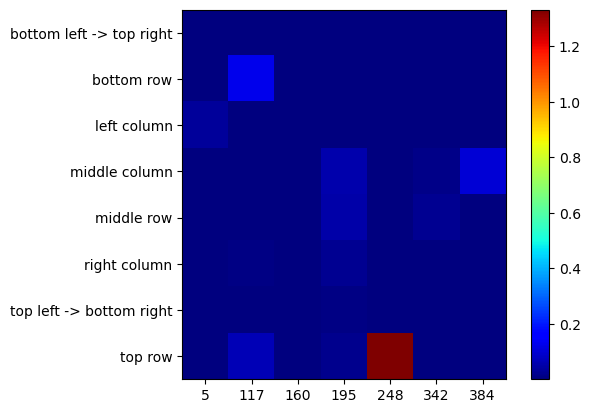

In [60]:
grouped = df_ablation_losses.groupby(["first win condition"])
plt.imshow(grouped.mean(), cmap="jet", interpolation="nearest")
plt.colorbar()
# legend
plt.xticks(np.arange(0, 7), labels=grouped.mean().columns)
# yticks
plt.yticks(np.arange(0, 8), labels=grouped.mean().index)
# dpi
plt.rcParams["figure.dpi"] = 150